In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
import numpy as np
from tqdm import tqdm
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.utils import to_categorical
import itertools
from tensorflow.keras.callbacks import EarlyStopping

In [7]:
label_data = pd.read_csv("../input/ucf101/UCF101TrainTestSplits-RecognitionTask/ucfTrainTestlist/classInd.txt", sep=' ', header=None)
label_data.columns=['index', 'labels']
print(label_data.shape)
label_data = label_data.drop(['index'], axis=1)
label_data.head()

(101, 2)


,labels
0,ApplyEyeMakeup
1,ApplyLipstick
2,Archery
3,BabyCrawling
4,BalanceBeam


In [4]:
print(label_data.shape)


(101, 1)


In [8]:
#Total Number of video folders for classification
len(label_data)

101

In [9]:
path=[]
for label in label_data.labels.values:
    path.append('../input/ucf101/UCF101/UCF-101/'+label+"/")
path[0]

'../input/ucf101/UCF101/UCF-101/ApplyEyeMakeup/'

In [10]:
print(len(path))

101


In [11]:
UCF101_frames = '/kaggle/working/UCF101_frames'

In [12]:
#Function for loading video files, Process and store in a data set
def saving_the_frames(datasets):
    if not os.path.exists(UCF101_frames):
            os.mkdir(UCF101_frames)
    
    
    #Iterate through each fodler corresponding to category
    folders = os.listdir(datasets)
#     (folders)
#each class_name is one folder example ApplyEyeMakeup
    for class_name in folders:
#         print(class_name)
        image_folder_path = os.path.join('/kaggle/working/UCF101_frames',class_name)
#         print(image_folder_path)
        if not os.path.exists(image_folder_path):
            os.mkdir(image_folder_path)
        video_path =  os.path.join('/kaggle/input/ucf101/UCF101/UCF-101',class_name)
#         print(video_path)
        
        for video_file_name in os.listdir(video_path):
#             print(video_file_name)
            if '.avi' not in video_file_name:
                continue
            name, ext = os.path.splitext(video_file_name)
#             print(name)
            video_frame_folder_path = os.path.join(image_folder_path,name)
#             print(video_frame_folder_path)
            if not os.path.exists(video_frame_folder_path):
                os.mkdir(video_frame_folder_path)

In [13]:
saving_the_frames('/kaggle/input/ucf101/UCF101/UCF-101')

In [14]:
from PIL import Image

#Function for Feature Extraction
def feature_extraction(video_path):
    width=80
    height=60
    sequence_length=10
    frames_list=[]
    
    name, ext = os.path.splitext(video_path)
    video_name=os.path.basename(name)
    folderName =os.path.dirname(video_path)
    file_name = os.path.basename(folderName)
    #fileName is folder name i.e. class name
#     print(file_name)
#     print(video_path)
    #print(a)
    #Read the Video
    video_reader = cv2.VideoCapture(video_path)
    #get the frame count
    frame_count=int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    #Calculate the interval after which frames will be added to the list
    skip_interval = max(int(frame_count/sequence_length), 1)
    #iterate through video frames
    for counter in range(sequence_length):
        #Set the current frame postion of the video
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, counter * skip_interval)
        #Read the current frame 
        ret, frame = video_reader.read()
        
        if not ret:
            break;
        #Resize the image
#         frame=cv2.resize(frame, (height, width))
#        print(frame.shape)
        #frame = frame/255
        #Append to the frame
        frame=cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
        frames_list.append(frame)
        array=np.array(frame)
        new_image = Image.fromarray(array)
        new_image.save('/kaggle/working/UCF101_frames/'+file_name+'/'+video_name
                       +'/'+video_name+str(counter)+'.png')
#         print(len(frames_list))
    video_reader.release()
    #Return the Frames List
    return frames_list

In [15]:
#Function for loading video files, Process and store in a data set
def load_video(datasets):
    global image
    label_index=0
    labels=[]
    images=[]
    
    #Iterate through each foler corresponding to category
    for folder in datasets:
        print(folder)
        for file in tqdm(os.listdir(folder)):
            #Get the path name for each video
            video_path = os.path.join(folder, file)
            #Extract the frames of the current video
            frames_list = feature_extraction(video_path)
            images.append(frames_list)
            labels.append(label_index)
        label_index+=1
    return np.array(images, dtype='float16'), np.array(labels, dtype='float16')

In [16]:
#Due to memory allocation problem. I will select first 10 folders for classification
images, labels = load_video(path[0:9])

../input/ucf101/UCF101/UCF-101/ApplyEyeMakeup/


100%|██████████| 145/145 [01:01<00:00,  2.37it/s]


../input/ucf101/UCF101/UCF-101/ApplyLipstick/


100%|██████████| 114/114 [00:49<00:00,  2.30it/s]


../input/ucf101/UCF101/UCF-101/Archery/


100%|██████████| 145/145 [01:05<00:00,  2.22it/s]


../input/ucf101/UCF101/UCF-101/BabyCrawling/


100%|██████████| 132/132 [01:02<00:00,  2.10it/s]


../input/ucf101/UCF101/UCF-101/BalanceBeam/


100%|██████████| 108/108 [00:41<00:00,  2.58it/s]


../input/ucf101/UCF101/UCF-101/BandMarching/


100%|██████████| 155/155 [01:20<00:00,  1.93it/s]


../input/ucf101/UCF101/UCF-101/BaseballPitch/


100%|██████████| 150/150 [00:40<00:00,  3.68it/s]


../input/ucf101/UCF101/UCF-101/Basketball/


100%|██████████| 134/134 [00:32<00:00,  4.13it/s]


../input/ucf101/UCF101/UCF-101/BasketballDunk/


100%|██████████| 131/131 [00:43<00:00,  3.00it/s]


In [45]:
print("hello")

hello


In [18]:
for root, dirs, files in os.walk('/kaggle/working/UCF101_frames/'):
    f = os.path.basename(root) 
    if(len(files)>0):
        print(files)
   

['v_ApplyEyeMakeup_g06_c076.png', 'v_ApplyEyeMakeup_g06_c070.png', 'v_ApplyEyeMakeup_g06_c077.png', 'v_ApplyEyeMakeup_g06_c071.png', 'v_ApplyEyeMakeup_g06_c072.png', 'v_ApplyEyeMakeup_g06_c073.png', 'v_ApplyEyeMakeup_g06_c078.png', 'v_ApplyEyeMakeup_g06_c074.png', 'v_ApplyEyeMakeup_g06_c075.png', 'v_ApplyEyeMakeup_g06_c079.png']
['v_ApplyEyeMakeup_g03_c012.png', 'v_ApplyEyeMakeup_g03_c015.png', 'v_ApplyEyeMakeup_g03_c018.png', 'v_ApplyEyeMakeup_g03_c019.png', 'v_ApplyEyeMakeup_g03_c013.png', 'v_ApplyEyeMakeup_g03_c014.png', 'v_ApplyEyeMakeup_g03_c016.png', 'v_ApplyEyeMakeup_g03_c017.png', 'v_ApplyEyeMakeup_g03_c010.png', 'v_ApplyEyeMakeup_g03_c011.png']
['v_ApplyEyeMakeup_g05_c049.png', 'v_ApplyEyeMakeup_g05_c044.png', 'v_ApplyEyeMakeup_g05_c043.png', 'v_ApplyEyeMakeup_g05_c045.png', 'v_ApplyEyeMakeup_g05_c042.png', 'v_ApplyEyeMakeup_g05_c040.png', 'v_ApplyEyeMakeup_g05_c047.png', 'v_ApplyEyeMakeup_g05_c046.png', 'v_ApplyEyeMakeup_g05_c041.png', 'v_ApplyEyeMakeup_g05_c048.png']
['v_App

In [19]:
print(images.shape)

(1214, 10, 240, 320, 3)


In [20]:
#Shapes
images.shape, pd.Series(labels).shape
print(labels[300])

2.0


In [21]:
print(type(images[0][0][0][0][0]))
print(images[0][0].shape)

<class 'numpy.float16'>
(240, 320, 3)


In [23]:
def merging_frames(frames):
    frames1 = frames[0]
    frames2 = frames[1]
    frames3 = frames[2]
    frames4 = frames[3]
    frames5 = frames[4]
    frames6 = frames[5]
    frames7 = frames[6]
    frames8 = frames[7]
    frames9 = frames[8]
    frames10 = frames[9]
    merged_image = frames1+frames2+frames3+frames4+frames5+frames6+frames7+frames8+frames9+frames10
#     print(frames1)
    merged_image=merged_image/10.0
    return merged_image

In [24]:
all_input=[]
all_labels=[]
for category,label in zip(images,labels):
#     print(label)
    #category is list of 10 frames
    im1=merging_frames(category[0:10])
#     im2=merging_frames(category[5:10])
#     im3=merging_frames(category[10:15])
    all_input.append(im1)
#     all_input.append(im2)
#     all_input.append(im3)
    all_labels.append(label)
#     all_labels.append(label)
#     all_labels.append(label)
print(len(all_labels))
    

1214


In [25]:
print(len(all_input))
print(len(all_labels))

1214
1214


In [32]:
a=all_input[367]
print(a)

[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]


In [33]:
# print(type(a[1][0][0]))
a=np.rint(a)
a = a.astype(np.int32)

In [35]:
dynamic_images = '/kaggle/working/dynamic_images'

In [36]:
if not os.path.exists(dynamic_images):
    os.mkdir(dynamic_images)

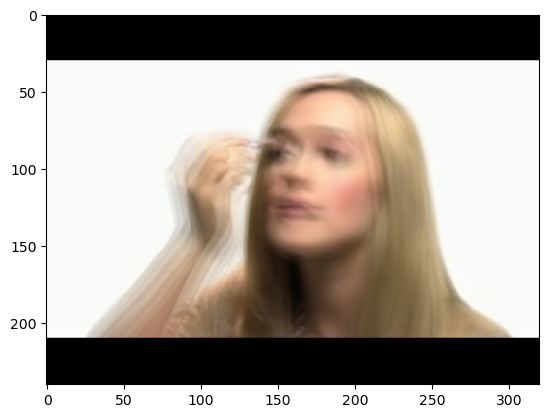

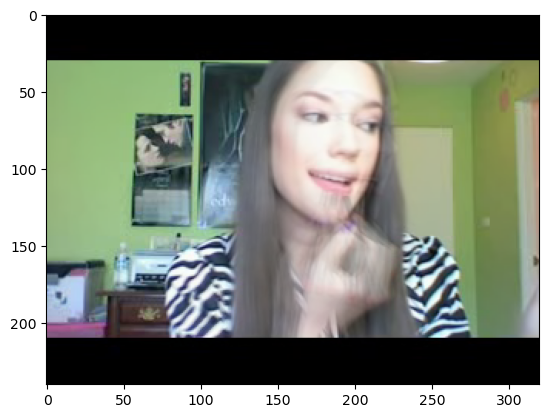

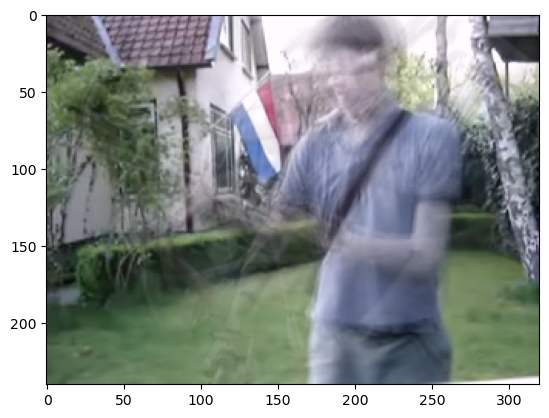

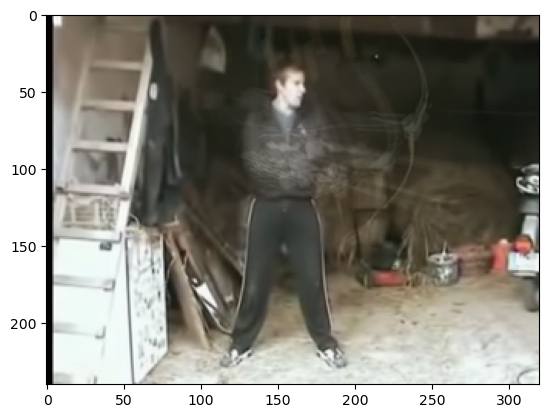

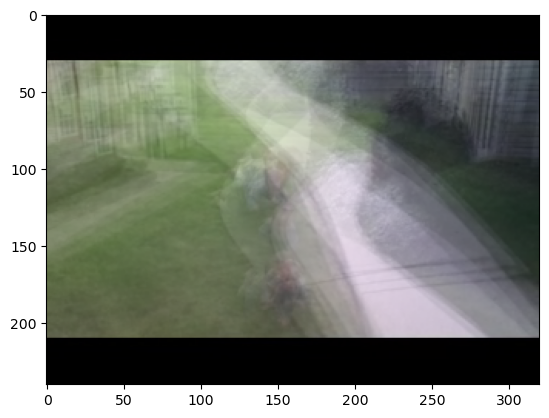

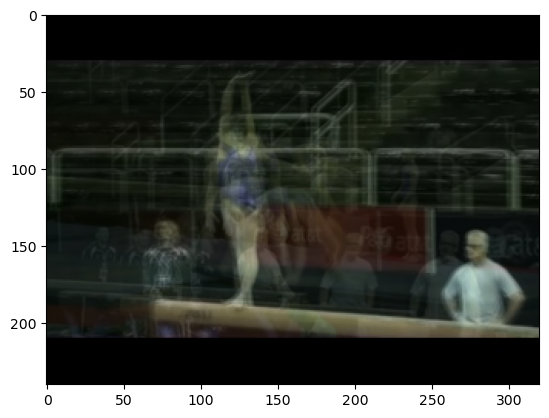

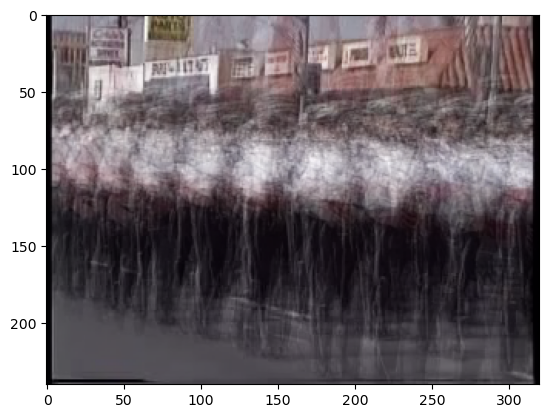

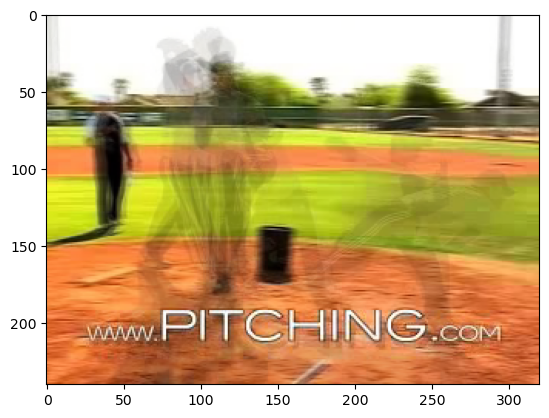

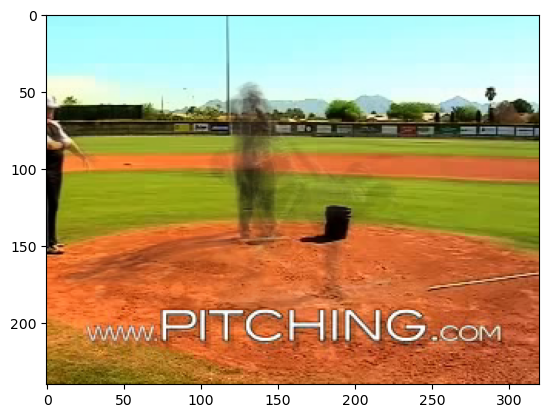

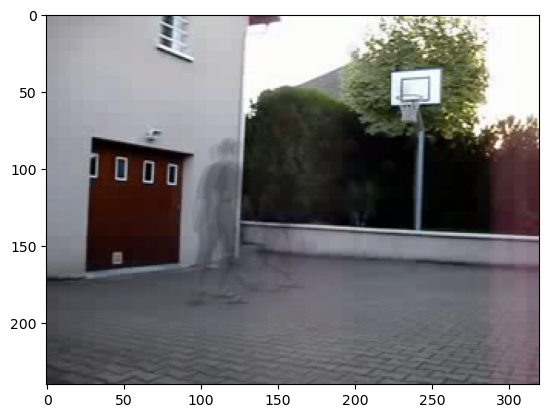

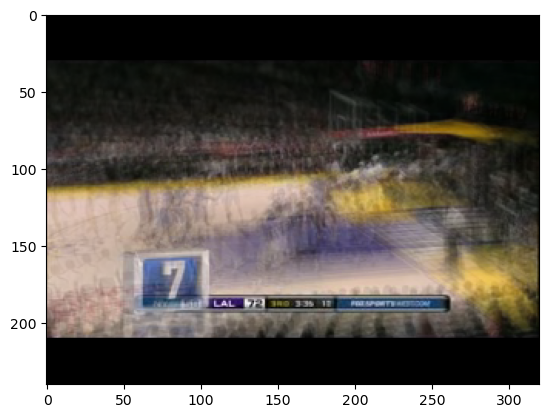

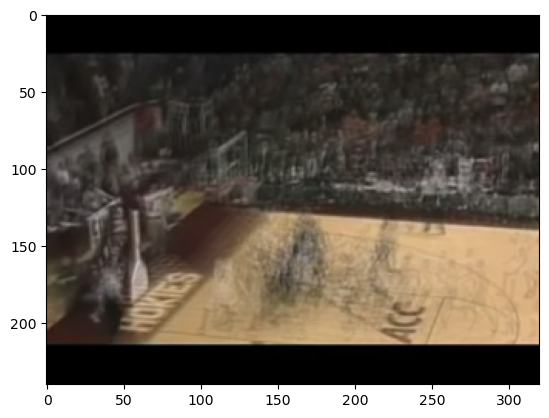

In [37]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
count = 0
for dynamic_image in all_input:
    count = count + 1
    a = dynamic_image
    a=np.rint(a)
    a = a.astype(np.int32)
    an = np.array(a.astype('uint8'))
    an = cv2.cvtColor(an, cv2.COLOR_BGR2RGB)
    if(count%100==0) :
        plt.imshow(a)
        plt.show()
    
    cv2.imwrite('/kaggle/working/dynamic_images/dynamic_image'+str(count)+'.png',an)
    
    

In [40]:
for root, dirs, files in os.walk('/kaggle/working/dynamic_images/'):
    f = os.path.basename(root) 
    print(len(files))
    print(files)

1214
['dynamic_image1074.png', 'dynamic_image14.png', 'dynamic_image1177.png', 'dynamic_image602.png', 'dynamic_image127.png', 'dynamic_image292.png', 'dynamic_image128.png', 'dynamic_image225.png', 'dynamic_image1204.png', 'dynamic_image113.png', 'dynamic_image1168.png', 'dynamic_image199.png', 'dynamic_image737.png', 'dynamic_image1205.png', 'dynamic_image789.png', 'dynamic_image655.png', 'dynamic_image289.png', 'dynamic_image63.png', 'dynamic_image719.png', 'dynamic_image925.png', 'dynamic_image488.png', 'dynamic_image818.png', 'dynamic_image1126.png', 'dynamic_image371.png', 'dynamic_image822.png', 'dynamic_image924.png', 'dynamic_image804.png', 'dynamic_image1191.png', 'dynamic_image727.png', 'dynamic_image443.png', 'dynamic_image73.png', 'dynamic_image182.png', 'dynamic_image52.png', 'dynamic_image129.png', 'dynamic_image1125.png', 'dynamic_image265.png', 'dynamic_image220.png', 'dynamic_image666.png', 'dynamic_image1034.png', 'dynamic_image409.png', 'dynamic_image667.png', 'dyna

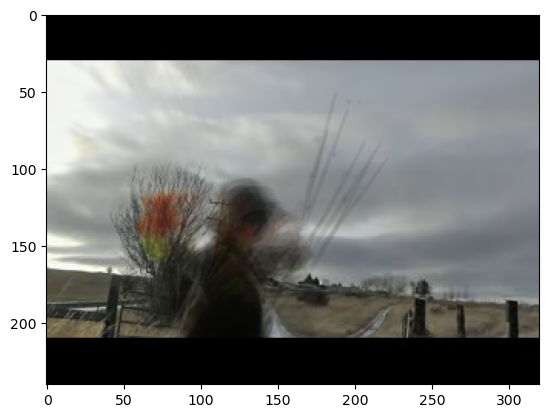

In [34]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
an = np.array(a.astype('uint8'))
an = cv2.cvtColor(an, cv2.COLOR_BGR2RGB)
plt.imshow(a)
plt.show()
# plt.savefig('random.png')

In [42]:
print(all_labels[1000])

7.0


In [73]:

# #Train Test Split
# x_train, x_test, y_train, y_test=train_test_split(all_input, all_labels, test_size=0.06, random_state=10)
# x_train=np.array(x_train)
# x_test=np.array(x_test)
# x_train.shape,x_test.shape, np.array(y_train).shape, np.array(y_test).shape

((730, 240, 320, 3), (47, 240, 320, 3), (730,), (47,))

In [43]:
!zip -r dynamic_images.zip /kaggle/working/dynamic_images

  adding: kaggle/working/dynamic_images/ (stored 0%)
  adding: kaggle/working/dynamic_images/dynamic_image1074.png (deflated 4%)
  adding: kaggle/working/dynamic_images/dynamic_image14.png (deflated 3%)
  adding: kaggle/working/dynamic_images/dynamic_image1177.png (deflated 1%)
  adding: kaggle/working/dynamic_images/dynamic_image602.png (deflated 3%)
  adding: kaggle/working/dynamic_images/dynamic_image127.png (deflated 3%)
  adding: kaggle/working/dynamic_images/dynamic_image292.png (deflated 1%)
  adding: kaggle/working/dynamic_images/dynamic_image128.png (deflated 3%)
  adding: kaggle/working/dynamic_images/dynamic_image225.png (deflated 2%)
  adding: kaggle/working/dynamic_images/dynamic_image1204.png (deflated 4%)
  adding: kaggle/working/dynamic_images/dynamic_image113.png (deflated 3%)
  adding: kaggle/working/dynamic_images/dynamic_image1168.png (deflated 2%)
  adding: kaggle/working/dynamic_images/dynamic_image199.png (deflated 2%)
  adding: kaggle/working/dynamic_images/dyna